# Bin Raw Data

select subset / remove outliers before binning


### Package Imports

In [10]:
# need to add parent directory to sys.path...
import sys
import os
import json

sys.path.append(os.path.dirname(os.getcwd()))
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from IPython.display import display
from PyOptimalInterpolation import get_data_path
from PyOptimalInterpolation.dataprepper import DataPrep
from PyOptimalInterpolation.utils import  stats_on_vals, EASE2toWGS84_New
from PyOptimalInterpolation.plot_utils import plot_pcolormesh, plot_hist

pd.set_option('display.max_columns', 200)

# Config / Parameters

to generate /data/example/ABC.h5 run: examples/read_and_store_raw_data.py

In [11]:

# configuration file
# - to be used with bin_data_by, after "input" and "output_file" are removed (popped)
bin_config = {
    "input":  {
        "file": get_data_path("example", "ABC.h5"),
        "table": "data"
    },
    "output_file": get_data_path("example", "ABC_binned.zarr"),
    "grid_res": 50 * 1000,
    "by_cols": ['source', 'date'],
    "val_col": "obs",
    "row_select": [
        {"col": "obs", "comp": ">=", "val": -2.0},
        {"col": "obs", "comp": "<=", "val": 2.0}
    ],
    "x_col": "x",
    "y_col": "y",
    "x_range": [-4500000.0, 4500000.0],
    "y_range": [-4500000.0, 4500000.0],
    "col_funcs": {
        "date": {
            "func": "lambda x: x.astype('datetime64[D]')",
            "col_args": "datetime"
        },
        "x": {
            "source": "PyOptimalInterpolation.utils",
            "func": "WGS84toEASE2_New",
            "col_kwargs": {"lon": "lon", "lat": "lat"},
            "kwargs": {"return_vals": "x"}
        },
        "y": {
            "source": "PyOptimalInterpolation.utils",
            "func": "WGS84toEASE2_New",
            "col_kwargs": {"lon": "lon", "lat": "lat"},
            "kwargs": {"return_vals": "y"}
        }
    }
}

# make a copy of the config - so can store as attribute
org_bin_config = bin_config.copy()

# pop out input and output_file
input_info = bin_config.pop('input')
output_file = bin_config.pop('output_file')


# --
# plot params
# --

scatter_plot_size = 2

# Read Raw Data

In [12]:
input_file = input_info['file']
table = input_info.get('table', "data")
where = input_info.get("where", None)

print("reading from hdf5 files")
with pd.HDFStore(input_file, mode='r') as store:
    df = store.select(table, where=where)

# get the raw data configuration - if it exists
try:
    with pd.HDFStore(input_file, mode='r') as store:
        raw_data_config = store.get_storer(table).attrs['config']
    # print(json.dumps(raw_data_config, indent=4))
except Exception as e:
    print(e)
    print("issue getting raw_data_config? it should exists in attrs")
    raw_data_config = None

print("head of data:")
print(df.head(3))


reading from hdf5 files
head of data:
         lon        lat            datetime source     obs
0 -57.190860  65.647048 2020-03-01 00:03:32      A -0.0670
1 -57.224372  65.679991 2020-03-01 00:03:36      A  0.0057
2 -57.227168  65.682736 2020-03-01 00:03:37      A -0.0996


# Stats on Raw Data

In [13]:
print("*" * 20)
print("summary / stats table on metric (use for trimming)")

val_col = bin_config['val_col']
vals = df[val_col].values
stats_df = stats_on_vals(vals=vals, name=val_col,
                         qs=[0.01, 0.05] + np.arange(0.1, 1.0, 0.1).tolist() + [0.95, 0.99])

# print(stats_df)
display(stats_df)

********************
summary / stats table on metric (use for trimming)


,obs
measure,NaN
size,1.037066e+06
num_not_nan,1.037066e+06
num_inf,0.000000e+00
min,-1.689650e+01
mean,2.912546e-02
max,1.660930e+01
std,1.857357e-01
skew,-1.080675e+01
kurtosis,9.112346e+02


In [14]:
# get a Dataset of binned data
ds_bin = DataPrep.bin_data_by(df=df, **bin_config)


'data_select': 0.242 seconds
'bin_data_by': 2.015 seconds


# Add lon,lat to coordinates

In [15]:
# add lon,lat grid values to coords
x_grid, y_grid = np.meshgrid(ds_bin.coords['x'], ds_bin.coords['y'])
lon_grid, lat_grid = EASE2toWGS84_New(x_grid, y_grid)

ds_bin = ds_bin.assign_coords({"lon": (['y', 'x'], lon_grid),
                               "lat": (['y', 'x'], lat_grid)})

# Store Binned Data to (zarr) File

In [16]:
# write to file - mode = 'w' will overwrite file
# DataLoader.write_to_netcdf(ds=ds_bin, path=output_file, mode="w")

# add attributes - so know how data was created
# NOTE: can't save netcdf file with nested dict as attributes...
ds_bin.attrs['raw_data_config'] = raw_data_config
ds_bin.attrs['bin_config'] = bin_config

ds_bin.to_zarr(output_file, mode="w")

# Review Binned Data

In [17]:
# all binned values
bin_obs = ds_bin[val_col].data
# average over date, source
# TODO: this should be more systematic
ave_obs = np.nanmean(ds_bin[val_col].data, axis=(2,3))

#
bin_stats_df = stats_on_vals(vals=bin_obs, name=val_col,
                             qs=[0.01, 0.05] + np.arange(0.1, 1.0, 0.1).tolist() + [0.95, 0.99])

print(bin_stats_df)

                       obs
measure                NaN
size         874800.000000
num_not_nan   19465.000000
num_inf           0.000000
min              -1.377300
mean              0.001561
max               1.215715
std               0.102397
skew             -0.839784
kurtosis         13.729256
q0.01            -0.303419
q0.05            -0.136269
q0.10            -0.093810
q0.20            -0.057301
q0.30            -0.035459
q0.40            -0.017977
q0.50            -0.003117
q0.60             0.013385
q0.70             0.034263
q0.80             0.065240
q0.90             0.119097
q0.95             0.164142
q0.99             0.258603


/tmp/ipykernel_82203/2451481753.py:5: RuntimeWarning: Mean of empty slice
  ave_obs = np.nanmean(ds_bin[val_col].data, axis=(2,3))


# Plot Binned Data
 taking average of values per grid cell


/home/buddy/miniconda3/envs/PyOI/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)


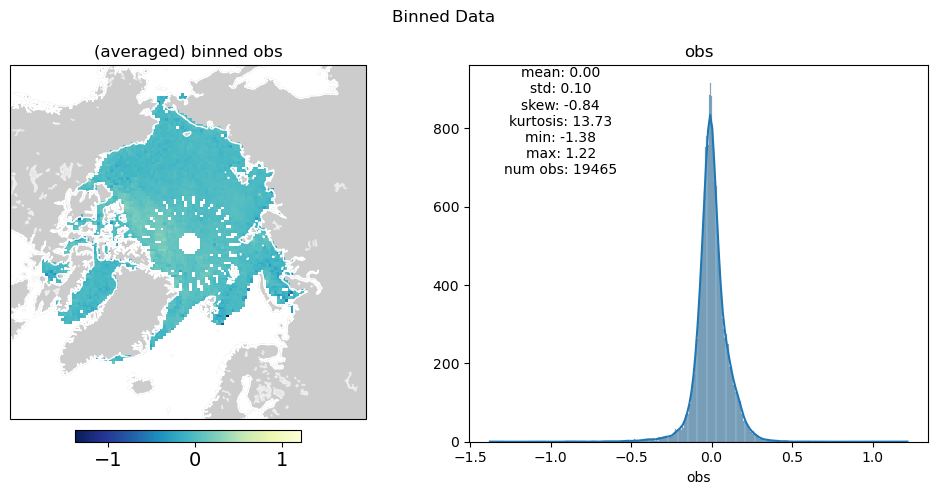

In [18]:

figsize = (10, 5)
fig = plt.figure(figsize=figsize)
fig.suptitle("Binned Data")

nrows, ncols = 1, 2

# first plot: heat map of observations
ax = fig.add_subplot(nrows, ncols, 1,
                     projection=ccrs.NorthPolarStereo())

plot_pcolormesh(ax=ax,
                lon=lon_grid,
                lat=lat_grid,
                plot_data=ave_obs,
                fig=fig,
                title=f"(averaged) binned {val_col}",
                # vmin=vmin,
                # vmax=vmax,
                cmap='YlGnBu_r',
                # cbar_label=cbar_labels[midx],
                scatter=False)

ax = fig.add_subplot(nrows, ncols, 2)

plot_hist(ax=ax,
          data=bin_obs[~np.isnan(bin_obs)],
          ylabel="",
          stats_values=['mean', 'std', 'skew', 'kurtosis', 'min', 'max', 'num obs'],
          title=val_col,
          xlabel=val_col,
          stats_loc=(0.2, 0.85))

plt.tight_layout()
plt.show()
